## Linear Regression

We will use the following two methods to complete linear regression, and compare **the differences** between the two methods.

* Least Square Method
* SGD


### Verifying the correctness of fully FC

In [1]:
import numpy as np
from check_gradient import eval_numerical_gradient_array
import fc

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

#### FC forward

In [2]:
num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = fc.affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

print('difference: ', rel_error(out, correct_out))

difference:  9.769848888397517e-10


#### FC backward

the different between formula gradient and numerical gradient must be little small

In [3]:
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: fc.affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: fc.affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: fc.affine_forward(x, w, b)[0], b, dout)

_, cache = fc.affine_forward(x, w, b)
dx, dw, db = fc.affine_backward(dout, cache)

# The error should be around 1e-10
print ('dx error: ', rel_error(dx_num, dx))
print ('dw error: ', rel_error(dw_num, dw))
print ('db error: ', rel_error(db_num, db))

dx error:  2.1605314711732498e-10
dw error:  1.9151427697996096e-10
db error:  1.939948015727141e-11


### Make dataset

In [4]:
import random
import numpy as np
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt

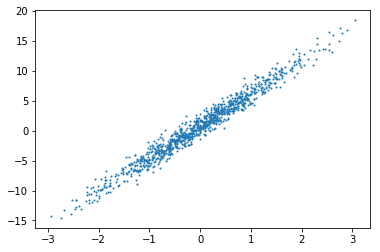

In [5]:
## sample 1
# X_train,y_train,coef = make_regression(n_samples=1000,n_features=1,noise=10,coef=True, bias=True)
# print(coef)

## sample 2
X_train = np.random.normal(scale=1,size=(1000,1))
y_train = 5.412 * X_train + 0.84 + np.random.normal(scale=1,size=(1000,1))
plt.scatter(X_train, y_train, s=1)
plt.show()


### Least Square Method
$$min_{w,b}\sum_i(y_i - (wx_i +b))^2$$
$$|Y-X*w|^2$$
对上面公式进行求导:
$$ Xw =Y$$
$$X^TXw =X^TY$$
$$w =(X^TX)^{-1}X^TY$$

In [6]:
# Incorporating biases into weights

bias_feature = np.ones((X_train.shape[0],1))
X_train_L = np.hstack([X_train, bias_feature]) 

w = np.linalg.inv(X_train_L.T.dot(X_train_L)).dot(X_train_L.T).dot(y_train)
print(w)

[[5.42088394]
 [0.85759116]]


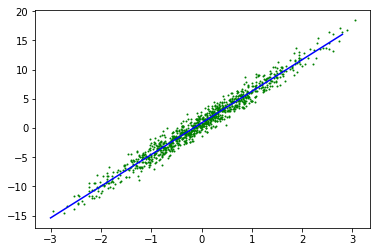

In [7]:
plt.scatter(X_train, y_train, s=1, c="g")
index_x = np.array([[i, 1] for i in np.arange(-3, 3, 0.2)])
plt.plot(index_x[:,0], index_x.dot(w), c="b")
plt.show()

### SGD
#### Define one FC layer
* the X is (batch, c1,c2,.. cn)
* network_config = {"input": number of features, "1":("fc",(input_dims, output_dims)), ...}

In [8]:
from model import Model
from loss import L2_loss

class Onefc(Model):
    def __init_(number_layer, network_config, weight_scale):
        super.__init__(number_layer, network_config, weight_scale)
    def inference_network(self, X):
        h1, cache = fc.affine_forward(X, self.params["W1"], self.params["b1"])
        return h1, cache

    def loss(self, X, y, mode="train"):
        h1, cache = self.inference_network(X)
        loss, dh1 = L2_loss(h1, y)
        grads = {}
        if mode=="train":
            df, grads["W1"], grads["b1"] = fc.affine_backward(dh1, cache)
        return loss, grads 

#### Define Solver
建立 solver这个类主要原因在于:优化参数随着迭代的进行在发生变化, 同时这种变化必须需要存储.

In [9]:
from solver import Solver
print(np.shape(y_train))
data = {
    "X_train":X_train,
    "y_train":y_train
}
one_fc = Onefc(number_layer=1, network_config ={"input":1, "1":("fc",(1,1))}, weight_scale=0.001)
solver = Solver(one_fc, data,  
                update_rule='sgd_momentum',
                optim_config={
                  'learning_rate': 1e-3},
                batch_size=200,
                print_every=1000)
solver.train(num_iterations=10000)

(1000, 1)
(Iteration 1001 / 10000) loss: 1.006126
(Iteration 2001 / 10000) loss: 1.086691
(Iteration 3001 / 10000) loss: 0.959451
(Iteration 4001 / 10000) loss: 0.970789
(Iteration 5001 / 10000) loss: 1.110114
(Iteration 6001 / 10000) loss: 0.795985
(Iteration 7001 / 10000) loss: 0.919669
(Iteration 8001 / 10000) loss: 0.985333
(Iteration 9001 / 10000) loss: 0.846889


[[5.41439948]] [0.85861476]


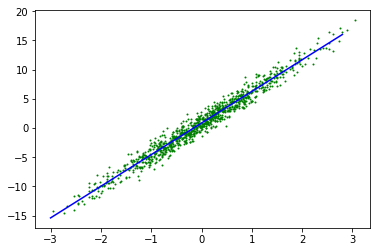

In [10]:
print(one_fc.params["W1"], one_fc.params["b1"])
plt.scatter(X_train, y_train, s=1, c="g")
index_x = np.array([[i] for i in np.arange(-3, 3, 0.2)])
plt.plot(index_x[:,0], one_fc.inference_network(index_x)[0], c="b")
plt.show()

### Conclusion  
两种方法最终的结果差别不大, 可以从两个角度去思考:
* 两个方法都是采用损失函数的一阶梯度进行优化.
* SGD采用的mini-batch的方式得到最终结果(局部最优), 和LSM利用全部样本得出的最优值(全局最优),结果相差不大. 说明mini-batch的有效性.